# Feature importances

In this notebook we generate the feature importance results shown in Table 6.

In [1]:
%matplotlib inline
import sys
import os
import time

import pandas as pd
import numpy as np

import CBECSLib
CBECSLib = reload(CBECSLib)

import itertools
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#sklearn base
import sklearn.base

#sklearn utility
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#sklearn models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#IPython utilities
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

In [ ]:
DATASET = 0

In [2]:
pbaLabels = CBECSLib.pbaLabels
pbaPlusLabels = CBECSLib.pbaPlusLabels

getDataset = CBECSLib.getDataset
getClassFrequencies = CBECSLib.getClassFrequencies
getDataSubset = CBECSLib.getDataSubset

# Print extended features

In [3]:
dataKey = {}
f = open("data/cbecs/2012_microdata_codebook.csv","r")
for line in f:
    key,value = map(str.strip,line.split("|"))
    if key!="":
        dataKey[key]=value
f.close()

In [4]:
X,Y,columnNames,classVals = getDataset(0,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

20 classes


In [5]:
for columnName in columnNames:
    if columnName in dataKey:
        print "%s,%s" % (columnName, dataKey[columnName])
    else:
        print columnName

FREESTN,Freestanding building
SQFT,Square footage
SQFTC,Square footage category
WLCNS,Wall construction material
RFCNS,Roof construction material
RFCOOL,Cool roof materials
RFTILT,Roof tilt
BLDSHP,Building shape
GLSSPC,Percent exterior glass
EQGLSS,Equal glass on all sides
NFLOOR,Number of floors
FLCEILHT,Floor to ceiling height
ATTIC,Attic
YRCON,Year of construction
YRCONC,Year of construction category
RENOV,Any renovations
RENADD,Addition or annex
RENRDC,Reduction of floorspace
RENCOS,Cosmetic improvements
RENINT,Interior wall re-configuration
RENRFF,Roof replacement
RENWLL,Exterior wall replacement
RENWIN,Window replacement
RENHVC,HVAC equipment upgrade
RENLGT,Lighting upgrade
RENPLB,Plumbing system upgrade
RENELC,Electrical upgrade
RENINS,Insulation upgrade
RENSAF,Fire, safety, or security upgrade
RENSTR,Structural upgrade
RENOTH,Other renovation
ONEACT,One activity in building
FACIL,On a multibuilding complex
GOVOWN,Government owned
OWNTYPE,Building owner
NOCC,Number of businesses

# Visualize Decision Tree

In [6]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [7]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)


regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.999999999859
Testing r2:  0.594907043182


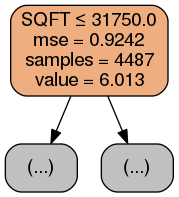

In [8]:
dot_data = export_graphviz(regressor, out_file=None, max_depth=0, feature_names=columnNames, filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

# Important Features

In [9]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)

regressor = GradientBoostingRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.83375348979
Testing r2:  0.775078156267


In [10]:
importances = regressor.feature_importances_

assert abs(np.sum(importances)-1) < 1e-5

k = 10
sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
    
    description = ""
    if columnNames[index] in dataKey:
        description = dataKey[columnNames[index]]
    else:
        description = columnNames[index]
    
    print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)

01	SQFT	0.3641	Square footage
02	HDD65	0.1318	Heating degree days (base 65)
03	CDD65	0.1100	Cooling degree days (base 65)
04	PBA 1	0.0495	PBA 1
05	PBA 5	0.0472	PBA 5
06	PBA 6	0.0400	PBA 6
07	PBA 15	0.0382	PBA 15
08	PBA 23	0.0356	PBA 23
09	PBA 12	0.0338	PBA 12
10	NFLOOR	0.0288	Number of floors


# Important features within PBA

In [11]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)


classOutputs = []

for i,classVal in enumerate(classOrdering):
    
    className = pbaLabels[classVal]
    numberOfSamples = classFrequencies[classVal]
    
    #if className!="Food service":
    #    continue
    
    startTime = float(time.time())
    print "%02d/%d\tRunning experiments for %s(n=%d)" % (i+1,len(classOrdering), className, numberOfSamples)
    print "-"*40
    X_temp, Y_temp, classVals_temp = CBECSLib.getDataSubsetWithClassvals(X,Y,classVals,classVal)
    
    rs = StratifiedShuffleSplit(n_splits=1, train_size=0.9, test_size=.1, random_state=0)
    train_index, test_index = next(rs.split(Y_temp,classVals_temp))

    X_train, X_test = X_temp[train_index], X_temp[test_index]
    Y_train, Y_test = Y_temp[train_index], Y_temp[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    
    regressor = GradientBoostingRegressor()
    regressor.fit(X_train_scaled,Y_train)
    
    print "Training r2: ",r2_score(Y_train, regressor.predict(X_train_scaled))
    print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test_scaled))

    print "-"*40
    print "-"*40
    
    importances = regressor.feature_importances_

    k = 15
    sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

    for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
        description = ""
        if columnNames[index] in dataKey:
            description = dataKey[columnNames[index]]
        else:
            description = columnNames[index]
        print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)
    
    
    print "Finished experiments in %0.4f seconds" % (time.time()-startTime)
    print "-"*40
    print "-"*40
    print ""

20 classes
01/20	Running experiments for Office(n=970)
----------------------------------------
Training r2:  0.956107119443
Testing r2:  0.869229374102
----------------------------------------
----------------------------------------
01	SQFT	0.1736	Square footage
02	NWKER	0.0526	Number of employees
03	HDD65	0.0413	Heating degree days (base 65)
04	CDD65	0.0350	Cooling degree days (base 65)
05	HEATP	0.0301	Percent heated
06	ZMFBTU	0.0247	Imputed major fuels consumption
07	YRCON	0.0211	Year of construction
08	GLSSPC	0.0210	Percent exterior glass
09	NGUSED	0.0208	Natural gas used
10	MAINHT	0.0203	Main heating equipment
11	FACIL	0.0198	On a multibuilding complex
12	PCTERMN	0.0191	Number of computers
13	LAPTPN	0.0175	Number of laptops
14	RFCNS	0.0167	Roof construction material
15	LTOHRP	0.0163	Percent lit when open
Finished experiments in 0.4174 seconds
----------------------------------------
----------------------------------------

02/20	Running experiments for Education(n=580)
---------